In [33]:
print("hello")

hello


In [34]:
!pip install tensorflow librosa soundfile scikit-learn pandas numpy matplotlib seaborn tqdm

In [35]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from typing import List, Tuple, Dict
import pandas as pd
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [36]:
plt.style.use('default')
sns.set_palette("husl")

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

In [38]:
CONFIG = {
    'AUDIO_DIR': "audio_augmented",
    'DATA_FILE': "final_txt_data.json",
    'SAMPLE_RATE': 16000,
    'MAX_AUDIO_LENGTH': 16000 * 10,
    'MAX_TEXT_LENGTH': 100,
    'N_MELS': 80,
    'BATCH_SIZE': 8,
    'EPOCHS': 50,
    'LEARNING_RATE': 0.001,
    'FIXED_SEQUENCE_LENGTH': 625  # ADD THIS LINE
}

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  AUDIO_DIR: audio_augmented
  DATA_FILE: final_txt_data.json
  SAMPLE_RATE: 16000
  MAX_AUDIO_LENGTH: 160000
  MAX_TEXT_LENGTH: 100
  N_MELS: 80
  BATCH_SIZE: 8
  EPOCHS: 50
  LEARNING_RATE: 0.001
  FIXED_SEQUENCE_LENGTH: 625


In [39]:
class SinhalaSTTDataProcessor:
    """Data processor for Sinhala Speech-to-Text model"""
    
    def __init__(self, sample_rate: int = 16000, max_length: int = 16000*10):
        self.sample_rate = sample_rate
        self.max_length = max_length
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0
        
    def build_vocabulary(self, texts: List[str]):
        """Build character-level vocabulary from text data"""
        all_chars = set()
        for text in texts:
            all_chars.update(text)
        
        # Add special tokens
        special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
        vocab = special_tokens + sorted(list(all_chars))
        
        self.char_to_idx = {char: idx for idx, char in enumerate(vocab)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(vocab)
        
        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Sample characters: {list(self.char_to_idx.keys())[:20]}")
        
        # Display vocabulary statistics
        char_counts = Counter(''.join(texts))
        print(f"\nMost common characters:")
        for char, count in char_counts.most_common(10):
            print(f"  '{char}': {count} times")
        
    def preprocess_audio(self, audio_path: str) -> np.ndarray:
        """Preprocess audio file to mel spectrogram features with fixed dimensions"""
        try:
            # Load audio
            audio, sr = librosa.load(audio_path, sr=self.sample_rate)
            
            # Pad or trim audio to fixed length
            if len(audio) > self.max_length:
                audio = audio[:self.max_length]
            else:
                audio = np.pad(audio, (0, self.max_length - len(audio)), 'constant')
            
            # Extract mel spectrogram with fixed parameters
            mel_spec = librosa.feature.melspectrogram(
                y=audio, 
                sr=self.sample_rate,
                n_mels=CONFIG['N_MELS'],
                n_fft=1024,
                hop_length=256,
                win_length=1024
            )
            
            # Convert to log scale and normalize
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            mel_spec = (mel_spec - np.mean(mel_spec)) / (np.std(mel_spec) + 1e-8)
            
            # Ensure fixed dimensions for TFLite
            mel_spec = mel_spec.T  # Shape: (time_steps, n_mels)
            
            # Fixed sequence length for TFLite compatibility
            if mel_spec.shape[0] > CONFIG['FIXED_SEQUENCE_LENGTH']:
                mel_spec = mel_spec[:CONFIG['FIXED_SEQUENCE_LENGTH'], :]
            else:
                pad_length = CONFIG['FIXED_SEQUENCE_LENGTH'] - mel_spec.shape[0]
                mel_spec = np.pad(mel_spec, ((0, pad_length), (0, 0)), 'constant')
            
            return mel_spec
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return np.zeros((CONFIG['FIXED_SEQUENCE_LENGTH'], CONFIG['N_MELS']))
    
    def text_to_sequence(self, text: str, max_length: int = None) -> List[int]:
        """Convert text to sequence of character indices"""
        if max_length is None:
            max_length = CONFIG['MAX_TEXT_LENGTH']
            
        sequence = [self.char_to_idx['<sos>']]
        
        for char in text:
            if char in self.char_to_idx:
                sequence.append(self.char_to_idx[char])
            else:
                sequence.append(self.char_to_idx['<unk>'])
        
        sequence.append(self.char_to_idx['<eos>'])
        
        # Pad or truncate to max_length
        if len(sequence) > max_length:
            sequence = sequence[:max_length]
        else:
            sequence.extend([self.char_to_idx['<pad>']] * (max_length - len(sequence)))
        
        return sequence
    
    def sequence_to_text(self, sequence: List[int]) -> str:
        """Convert sequence of indices back to text"""
        text = ""
        for idx in sequence:
            if idx in self.idx_to_char:
                char = self.idx_to_char[idx]
                if char in ['<pad>', '<sos>', '<eos>']:
                    continue
                elif char == '<unk>':
                    text += '?'
                else:
                    text += char
        return text

print("‚úì Data processor class defined")

‚úì Data processor class defined


In [40]:
# Load data
try:
    with open(CONFIG['DATA_FILE'], 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    print(f"‚úì Loaded {len(data_dict)} samples from {CONFIG['DATA_FILE']}")
except FileNotFoundError:
    print(f"‚ùå Data file '{CONFIG['DATA_FILE']}' not found!")
    print("Please make sure your data.json file is in the current directory")
    # Create a sample data structure for demonstration
    data_dict = {
        "1": {
            "newfn": "sample_audio.wav",
            "text": "‡∑É‡∑è‡∂∏‡∑ä‡∂¥‡∂Ω‡∑ä ‡∂ß‡∑ô‡∂ö‡∑ä‡∑É‡∑ä‡∂ß‡∑ä",
            "duration": 3.5
        }
    }
    print("Created sample data structure for demonstration")

# Display data statistics
print(f"\nData Statistics:")
print(f"Total samples: {len(data_dict)}")

# Text statistics
texts = [item['text'] for item in data_dict.values()]
durations = [item.get('duration', 0) for item in data_dict.values()]

print(f"Average text length: {np.mean([len(text) for text in texts]):.1f} characters")
print(f"Average audio duration: {np.mean(durations):.1f} seconds")

# Display first few samples
print(f"\nFirst 3 samples:")
for i, (key, item) in enumerate(list(data_dict.items())[:3]):
    print(f"  {i+1}. File: {item['newfn']}")
    print(f"     Text: {item['text']}")
    print(f"     Duration: {item.get('duration', 'N/A')} seconds")

‚úì Loaded 5364 samples from final_txt_data.json

Data Statistics:
Total samples: 5364
Average text length: 73.9 characters
Average audio duration: 7.4 seconds

First 3 samples:
  1. File: pn_sin_01_00001.wav
     Text: ‡∂ö‡∑î‡∂π‡∑î‡∂ª ‡∂ú‡∑ú‡∑Ä‡∑í‡∂∫‡∑è‡∂ß ‡∑Ä‡∑ì ‡∂Ω‡∂∂‡∑è ‡∂ú‡∑ê‡∂±‡∑ì‡∂∏‡∂ß ‡∂ã‡∂¥‡∂ö‡∑è‡∂ª‡∑ì ‡∑Ä‡∑ì‡∂∏‡∑ä ‡∑Ä‡∑Å‡∂∫‡∑ô‡∂±‡∑ä ‡∂¥‡∑í‡∑Ñ‡∑í‡∂ß ‡∑Ä‡∂±‡∑ä‡∂±‡∂ö‡∑í.
     Duration: 4.996644 seconds
  2. File: pn_sin_01_00002.wav
     Text: ‡∂ë‡∑Ñ‡∑ô‡∂≠‡∑ä ‡∂ú‡∑ú‡∑Ä‡∑í‡∂∫‡∑è ‡∑Ä‡∑ì ‡∂Ω‡∂∂‡∑è ‡∂ú‡∂±‡∑î‡∂∫‡∑ö ‡∂î‡∑Ñ‡∑î‡∂ú‡∑ö ‡∂∏‡∑Ñ‡∂≠‡∑ä ‡∑Ä‡∑ñ ‡∑Ä‡∑ì‡∂ª‡∑ä‡∂∫‡∑ä‡∂∫‡∂∫‡∑ô‡∂±‡∑í.
     Duration: 4.535465 seconds
  3. File: pn_sin_01_00003.wav
     Text: ‡∂ú‡∑ú‡∑Ä‡∑í‡∂∫‡∑è ‡∂ú‡∑ö ‡∂¥‡∑ä‡∂ª‡∂∫‡∑ù‡∂¢‡∂±‡∂∫ ‡∂¥‡∑í‡∂´‡∑í‡∑É ‡∂Ö‡∂Ω‡∑ä‡∂¥ ‡∑Ä‡∑ä‡∂∫‡∑è‡∂∫‡∑è‡∂∏‡∂∫‡∂ö‡∑î‡∂Ø‡∑î ‡∂ö‡∑î‡∂π‡∑î‡∂ª ‡∂±‡∑ú ‡∂ö‡∂ª‡∂±‡∑ä‡∂±‡∑ö ‡∂∫.
     Duration: 5.297234 seconds


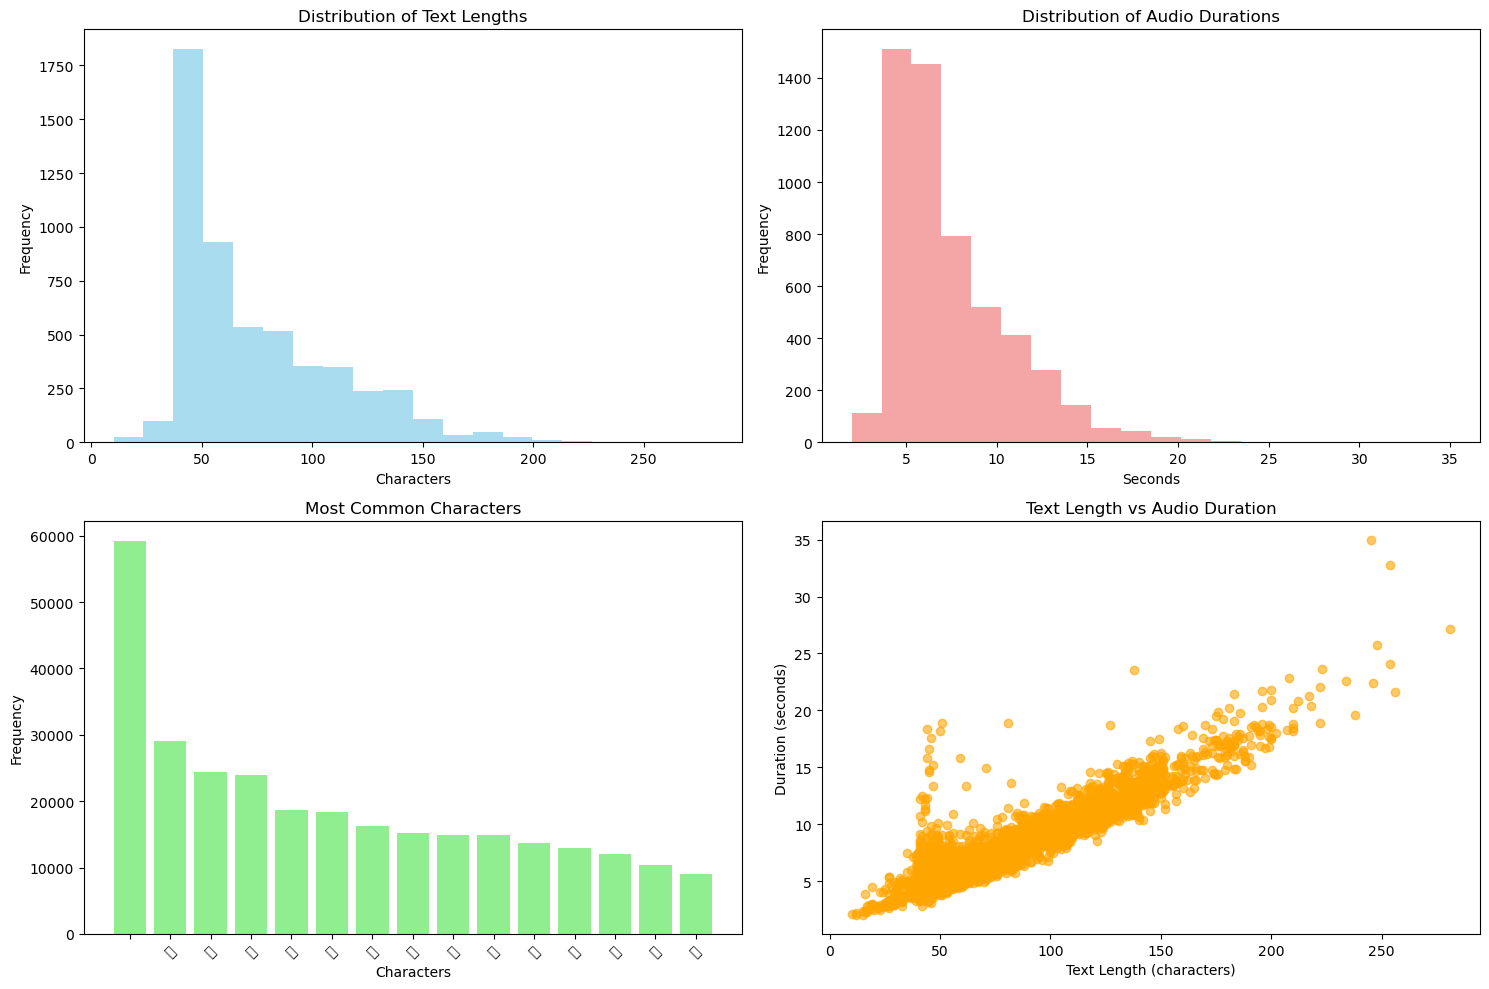

In [41]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length distribution
text_lengths = [len(text) for text in texts]
axes[0, 0].hist(text_lengths, bins=20, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribution of Text Lengths')
axes[0, 0].set_xlabel('Characters')
axes[0, 0].set_ylabel('Frequency')

# Duration distribution
axes[0, 1].hist(durations, bins=20, alpha=0.7, color='lightcoral')
axes[0, 1].set_title('Distribution of Audio Durations')
axes[0, 1].set_xlabel('Seconds')
axes[0, 1].set_ylabel('Frequency')

# Character frequency
all_chars = ''.join(texts)
char_counts = Counter(all_chars)
common_chars = char_counts.most_common(15)
chars, counts = zip(*common_chars)
axes[1, 0].bar(range(len(chars)), counts, color='lightgreen')
axes[1, 0].set_title('Most Common Characters')
axes[1, 0].set_xlabel('Characters')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xticks(range(len(chars)))
axes[1, 0].set_xticklabels(chars, rotation=45)

# Text length vs Duration scatter
if len(durations) > 1 and any(d > 0 for d in durations):
    axes[1, 1].scatter(text_lengths, durations, alpha=0.6, color='orange')
    axes[1, 1].set_title('Text Length vs Audio Duration')
    axes[1, 1].set_xlabel('Text Length (characters)')
    axes[1, 1].set_ylabel('Duration (seconds)')
else:
    axes[1, 1].text(0.5, 0.5, 'No duration data available', 
                   transform=axes[1, 1].transAxes, ha='center', va='center')
    axes[1, 1].set_title('Text Length vs Audio Duration')

plt.tight_layout()
plt.show()

In [42]:
# Initialize processor
processor = SinhalaSTTDataProcessor(
    sample_rate=CONFIG['SAMPLE_RATE'],
    max_length=CONFIG['MAX_AUDIO_LENGTH']
)

# Build vocabulary
print("Building vocabulary...")
processor.build_vocabulary(texts)

# Visualize vocabulary
vocab_chars = list(processor.char_to_idx.keys())[4:]  # Skip special tokens
print(f"\nVocabulary (first 50 characters): {vocab_chars[:50]}")

Building vocabulary...
Vocabulary size: 90
Sample characters: ['<pad>', '<sos>', '<eos>', '<unk>', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', '‡∂Ç', '‡∂É', '‡∂Ö', '‡∂Ü', '‡∂á']

Most common characters:
  ' ': 59260 times
  '‡∑ä': 29080 times
  '‡∑í': 24429 times
  '‡∂±': 23931 times
  '‡∂∫': 18596 times
  '‡∑Ä': 18428 times
  '‡∂ö': 16239 times
  '‡∂∏': 15230 times
  '‡∑è': 14943 times
  '‡∂≠': 14916 times

Vocabulary (first 50 characters): [' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', '‡∂Ç', '‡∂É', '‡∂Ö', '‡∂Ü', '‡∂á', '‡∂à', '‡∂â', '‡∂ä', '‡∂ã', '‡∂å', '‡∂ç', '‡∂ë', '‡∂í', '‡∂ì', '‡∂î', '‡∂ï', '‡∂ñ', '‡∂ö', '‡∂õ', '‡∂ú', '‡∂ù', '‡∂û', '‡∂ü', '‡∂†', '‡∂°', '‡∂¢', '‡∂£', '‡∂§', '‡∂•', '‡∂ß', '‡∂®', '‡∂©', '‡∂™', '‡∂´', '‡∂¨', '‡∂≠', '‡∂Æ', '‡∂Ø', '‡∂∞']


In [43]:
class SinhalaSTTModel:
    """Improved Sinhala STT model with TFLite compatibility"""
    
    def __init__(self, vocab_size: int, max_text_length: int = 100):
        self.vocab_size = vocab_size
        self.max_text_length = max_text_length
        self.model = None
        
    def build_model(self):
        """Build TFLite-compatible model architecture"""
        print("Building TFLite-compatible model architecture...")
        
        # Fixed input shapes for TFLite
        audio_input = keras.Input(
            shape=(CONFIG['FIXED_SEQUENCE_LENGTH'], CONFIG['N_MELS']), 
            name='audio_input'
        )
        decoder_input = keras.Input(
            shape=(self.max_text_length - 1,), 
            name='decoder_input'
        )
        
        # Encoder - More TFLite-friendly architecture
        print("  Adding encoder layers...")
        x = layers.Conv1D(64, 3, activation='relu', padding='same')(audio_input)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.2)(x)
        
        x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)
        x = layers.Dropout(0.2)(x)
        
        # Use GRU instead of LSTM for better TFLite support
        x = layers.GRU(128, return_sequences=True)(x)
        x = layers.Dropout(0.3)(x)
        encoder_output = layers.GRU(128, return_sequences=True)(x)
        
        # Decoder
        print("  Adding decoder layers...")
        decoder_embedding = layers.Embedding(self.vocab_size, 128)(decoder_input)
        decoder_gru = layers.GRU(256, return_sequences=True)(decoder_embedding)
        
        # Simplified attention mechanism
        print("  Adding attention mechanism...")
        # Global average pooling for context
        encoder_context = layers.GlobalAveragePooling1D()(encoder_output)
        encoder_context = layers.RepeatVector(self.max_text_length - 1)(encoder_context)
        
        # Concatenate context with decoder output
        concat = layers.Concatenate()([decoder_gru, encoder_context])
        
        # Output layers
        x = layers.Dense(256, activation='relu')(concat)
        x = layers.Dropout(0.3)(x)
        output = layers.Dense(self.vocab_size, activation='softmax')(x)
        
        # Create model
        self.model = keras.Model(
            inputs=[audio_input, decoder_input],
            outputs=output,
            name='sinhala_stt_model'
        )
        
        print("‚úì TFLite-compatible model architecture built successfully")
        return self.model
    
    def compile_model(self):
        """Compile the model"""
        print("Compiling model...")
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        print("‚úì Model compiled successfully")

# Initialize model
model = SinhalaSTTModel(vocab_size=processor.vocab_size, max_text_length=CONFIG['MAX_TEXT_LENGTH'])
model.build_model()
model.compile_model()

# Display model summary
print("\nModel Summary:")
model.model.summary()

Building TFLite-compatible model architecture...
  Adding encoder layers...
  Adding decoder layers...
  Adding attention mechanism...
‚úì TFLite-compatible model architecture built successfully
Compiling model...
‚úì Model compiled successfully

Model Summary:


Model: "sinhala_stt_model"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ audio_input         ‚îÇ (None, 625, 80)   ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_6 (Conv1D)   ‚îÇ (None, 625, 64)   ‚îÇ     15,424 ‚îÇ audio_input[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 625, 64)   ‚îÇ        256 ‚îÇ conv1d_6[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d_4     ‚îÇ (None, 312, 64)   ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (MaxPooling1D)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_7 (Dropout) ‚îÇ (None, 312, 64)   ‚îÇ          0 ‚îÇ max_pooling1d_4[‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_7 (Conv1D)   ‚îÇ (None, 312, 128)  ‚îÇ     24,704 ‚îÇ dropout_7[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalizatio‚Ä¶ ‚îÇ (None, 312, 128)  ‚îÇ        512 ‚îÇ conv1d_7[0][0]    ‚îÇ
‚îÇ (BatchNormalizatio‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d_5     ‚îÇ (None, 156, 128)  ‚îÇ          0 ‚îÇ batch_normalizat‚Ä¶ ‚îÇ
‚îÇ (MaxPooling1D)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout) ‚îÇ (None, 156, 128)  ‚îÇ          0 ‚îÇ max_pooling1d_5[‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ gru_3 (GRU)         ‚îÇ (None, 156, 128)  ‚îÇ     99,072 ‚îÇ dropout_8[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚

 Total params: 668,698 (2.55 MB)

 Trainable params: 668,314 (2.55 MB)

 Non-trainable params: 384 (1.50 KB)

In [44]:
def create_dataset(data_dict: Dict, processor: SinhalaSTTDataProcessor, audio_dir: str):
    """Create dataset from the data dictionary"""
    
    audio_features = []
    text_sequences = []
    decoder_inputs = []
    decoder_targets = []
    
    print("Processing audio files and texts...")
    
    # Use tqdm for progress bar
    for key, item in tqdm(data_dict.items(), desc="Processing samples"):
        audio_path = os.path.join(audio_dir, item['newfn'])
        text = item['text']
        
        if not os.path.exists(audio_path):
            print(f"‚ö†Ô∏è  Audio file not found: {audio_path}")
            continue
        
        # Process audio
        audio_feature = processor.preprocess_audio(audio_path)
        audio_features.append(audio_feature)
        
        # Process text
        text_seq = processor.text_to_sequence(text)
        text_sequences.append(text_seq)
        
        # Create decoder input (shifted by one position)
        decoder_input = text_seq[:-1]  # Remove <eos>
        decoder_target = text_seq[1:]   # Remove <sos>
        
        decoder_inputs.append(decoder_input)
        decoder_targets.append(decoder_target)
    
    print(f"‚úì Successfully processed {len(audio_features)} samples")
    
    return {
        'audio_features': np.array(audio_features),
        'decoder_inputs': np.array(decoder_inputs),
        'decoder_targets': np.array(decoder_targets)
    }

# Check if audio directory exists
if not os.path.exists(CONFIG['AUDIO_DIR']):
    print(f"‚ö†Ô∏è  Audio directory '{CONFIG['AUDIO_DIR']}' not found!")
    print("Creating dummy data for demonstration...")
    
    # Create dummy data for demonstration
    n_samples = len(data_dict)
    dataset = {
        'audio_features': np.random.randn(n_samples, 625, CONFIG['N_MELS']),
        'decoder_inputs': np.random.randint(0, processor.vocab_size, (n_samples, CONFIG['MAX_TEXT_LENGTH']-1)),
        'decoder_targets': np.random.randint(0, processor.vocab_size, (n_samples, CONFIG['MAX_TEXT_LENGTH']-1))
    }
    print("‚úì Created dummy dataset for demonstration")
else:
    # Create actual dataset
    dataset = create_dataset(data_dict, processor, CONFIG['AUDIO_DIR'])

print(f"\nDataset shapes:")
print(f"  Audio features: {dataset['audio_features'].shape}")
print(f"  Decoder inputs: {dataset['decoder_inputs'].shape}")
print(f"  Decoder targets: {dataset['decoder_targets'].shape}")


Processing audio files and texts...


Processing samples:   0%|          | 0/5364 [00:00<?, ?it/s]

‚ö†Ô∏è  Audio file not found: audio_augmented\pn_sin_01_00007.wav
‚ö†Ô∏è  Audio file not found: audio_augmented\pn_sin_01_00012.wav
‚úì Successfully processed 5362 samples

Dataset shapes:
  Audio features: (5362, 625, 80)
  Decoder inputs: (5362, 99)
  Decoder targets: (5362, 99)


In [45]:
# Split data
print("Splitting data into train and validation sets...")
indices = np.arange(len(dataset['audio_features']))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

# Create train and validation datasets
train_data = (
    [dataset['audio_features'][train_idx], dataset['decoder_inputs'][train_idx]],
    dataset['decoder_targets'][train_idx]
)

val_data = (
    [dataset['audio_features'][val_idx], dataset['decoder_inputs'][val_idx]],
    dataset['decoder_targets'][val_idx]
)

print("‚úì Data split completed")


Splitting data into train and validation sets...
Training samples: 4289
Validation samples: 1073
‚úì Data split completed


In [46]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_sinhala_stt_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("‚úì Training callbacks configured")
print("Callbacks:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

‚úì Training callbacks configured
Callbacks:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint


In [47]:
print("üöÄ Starting model training...")
print(f"Configuration:")
print(f"  Epochs: {CONFIG['EPOCHS']}")
print(f"  Batch size: {CONFIG['BATCH_SIZE']}")
print(f"  Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"  Training samples: {len(train_idx)}")
print(f"  Validation samples: {len(val_idx)}")

# Train the model
history = model.model.fit(
    train_data[0],  # inputs: [audio_features, decoder_inputs]
    train_data[1],  # targets: decoder_targets
    validation_data=(val_data[0], val_data[1]),
    epochs=CONFIG['EPOCHS'],
    batch_size=CONFIG['BATCH_SIZE'],
    callbacks=callbacks,
    verbose=1
)

print("‚úÖ Training completed!")

üöÄ Starting model training...
Configuration:
  Epochs: 50
  Batch size: 8
  Learning rate: 0.001
  Training samples: 4289
  Validation samples: 1073
Epoch 1/50
537/537 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 99ms/step - accuracy: 0.4420 - loss: 2.2447
Epoch 1: val_loss improved from inf to 1.69190, saving model to best_sinhala_stt_model.keras
537/537 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 106ms/step - accuracy: 0.4421 - loss: 2.2442 - val_accuracy: 0.5244 - val_loss: 1.6919 - learning_rate: 0.0010
Epoch 2/50
537/537 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 88ms/step - accuracy: 0.5202 - loss: 1.7036
Epoch 2: val_loss improved from 1.69190 to 1.52466, saving model to best_sinhala_stt_model.keras
537/537 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 50s 92ms/step - accuracy: 0.5203 - loss: 1.7035 - val_accuracy: 0.5658 - val_loss: 1.5247 - learning_rate: 0.0010
Epoch 3/50
537/537 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

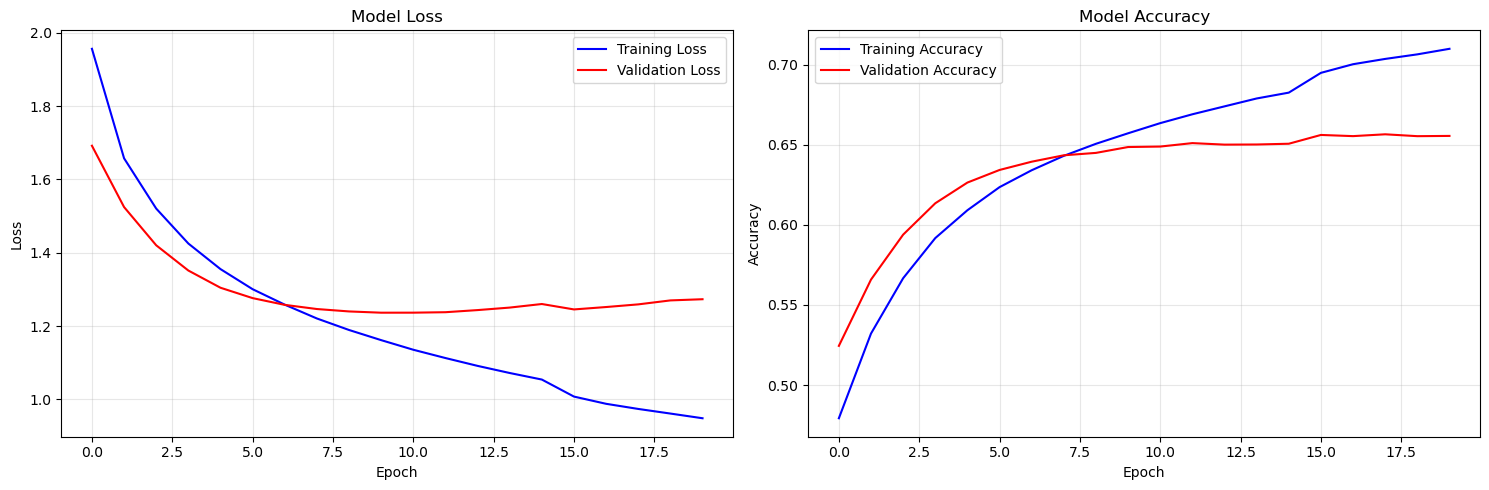


üìä Final Training Results:
  Training Loss: 0.9487
  Validation Loss: 1.2733
  Training Accuracy: 0.7099
  Validation Accuracy: 0.6555
üíæ Saving model and processor...
‚úì Processor saved to 'sinhala_stt_processor.pkl'
‚úì Model saved to 'sinhala_stt_model.keras'
‚úì Model also saved to 'sinhala_stt_model.h5' for compatibility


In [48]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation loss
axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot training & validation accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nüìä Final Training Results:")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")

# ====================================================================================================
# CELL 13: Save Model and Processor
# ====================================================================================================

# Save the processor
print("üíæ Saving model and processor...")

with open('sinhala_stt_processor.pkl', 'wb') as f:
    pickle.dump(processor, f)
print("‚úì Processor saved to 'sinhala_stt_processor.pkl'")

# Save model in different formats
model.model.save('sinhala_stt_model.keras')
print("‚úì Model saved to 'sinhala_stt_model.keras'")

# Also save in H5 format if needed for compatibility
try:
    model.model.save('sinhala_stt_model.h5')
    print("‚úì Model also saved to 'sinhala_stt_model.h5' for compatibility")
except Exception as e:
    print(f"‚ö†Ô∏è Could not save H5 format: {e}")


In [49]:
def convert_to_tflite_improved(model, model_path: str = 'sinhala_stt_model.tflite'):
    """Improved TensorFlow Lite conversion with better error handling"""
    print("üîÑ Converting model to TensorFlow Lite (improved method)...")
    
    try:
        # Method 1: Standard conversion with resource variables
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.experimental_enable_resource_variables = True
        
        try:
            tflite_model = converter.convert()
            
            with open(model_path, 'wb') as f:
                f.write(tflite_model)
            
            model_size = os.path.getsize(model_path) / (1024 * 1024)
            print(f"‚úÖ TensorFlow Lite model saved to: {model_path}")
            print(f"üìè Model size: {model_size:.2f} MB")
            return True
            
        except Exception as e1:
            print(f"Method 1 failed: {e1}")
            
            # Method 2: With SELECT_TF_OPS
            print("Trying method 2 with SELECT_TF_OPS...")
            converter = tf.lite.TFLiteConverter.from_keras_model(model)
            converter.optimizations = [tf.lite.Optimize.DEFAULT]
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS
            ]
            converter._experimental_lower_tensor_list_ops = False
            
            try:
                tflite_model = converter.convert()
                
                with open(model_path, 'wb') as f:
                    f.write(tflite_model)
                
                model_size = os.path.getsize(model_path) / (1024 * 1024)
                print(f"‚úÖ TensorFlow Lite model saved to: {model_path}")
                print(f"üìè Model size: {model_size:.2f} MB")
                print("‚ö†Ô∏è  Note: This model uses SELECT_TF_OPS and may not work on all devices")
                return True
                
            except Exception as e2:
                print(f"Method 2 also failed: {e2}")
                return False
                
    except Exception as e:
        print(f"‚ùå All conversion methods failed: {e}")
        return False

# Replace the function call
tflite_success = convert_to_tflite_improved(model.model)

üîÑ Converting model to TensorFlow Lite (improved method)...
INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpbauv4ugv\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpbauv4ugv\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmpbauv4ugv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 625, 80), dtype=tf.float32, name='audio_input'), TensorSpec(shape=(None, 99), dtype=tf.float32, name='decoder_input')]
Output Type:
  TensorSpec(shape=(None, 99, 90), dtype=tf.float32, name=None)
Captures:
  2063536670288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536670864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536673360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536674128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536674512: TensorSpec(shape=(), dtype=tf.resource, name=None)


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpu80rs8_3\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmpu80rs8_3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 625, 80), dtype=tf.float32, name='audio_input'), TensorSpec(shape=(None, 99), dtype=tf.float32, name='decoder_input')]
Output Type:
  TensorSpec(shape=(None, 99, 90), dtype=tf.float32, name=None)
Captures:
  2063536670288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536670864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536671632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536673360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536674128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2063536674512: TensorSpec(shape=(), dtype=tf.resource, name=None)
